Attempt to create a dataset using data from previous n years, let's start easy with n=1

In [1]:
import sys
import time
sys.path.append("..")
import utils
import utils.config
import pandas as pd
import sqlite3
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [2]:
conn = sqlite3.connect('../db.sqlite3')

indicators = utils.config.INDICATORS
target = utils.config.TARGET
separator = "',\n'"
sql_string = f""" SELECT
                t2.Country,
                t1.Year,
                t3.IndicatorName,
                t1.Value                
                FROM CountryIndicators t1
                LEFT JOIN
                (SELECT ShortName as Country, CountryCode from Countries) t2
                ON t1.CountryCode = t2.CountryCode
                LEFT JOIN
                (SELECT IndicatorCode, IndicatorName from Indicators)t3
                ON t1.IndicatorCode = t3.IndicatorCode
                WHERE t3.IndicatorName in ('{separator.join(indicators)}');"""
                # WHERE t3.IndicatorName not in ('GDP per capita growth (annual %)')"""

raw_df = pd.read_sql(sql_string,conn)

In [3]:
df = raw_df.groupby(["Country","Year","IndicatorName"]).sum().squeeze().unstack()
df = df.reset_index(level=["Country","Year"])
print(df.shape)

# Rows where our target is not missing
df = df[df[target].notna()]

# columns with not many missing values
print(df.shape)
df = df.dropna(axis='columns',thresh=0)
print(df.shape)
df3 = df.dropna()
print(df3.shape)
features = df3.columns.tolist()
features.remove(target)
features.remove("Country")
# features.remove("Year")
df.dtypes

(12537, 23)
(9057, 23)
(9057, 23)
(478, 23)


IndicatorName
Country                                                                               object
Year                                                                                   int64
Foreign direct investment, net inflows (% of GDP)                                    float64
Foreign direct investment, net outflows (% of GDP)                                   float64
GDP growth (annual %)                                                                float64
GNI growth (annual %)                                                                float64
General government final consumption expenditure (% of GDP)                          float64
Inflation, GDP deflator (annual %)                                                   float64
Population ages 0-14 (% of total)                                                    float64
Population ages 15-64 (% of total)                                                   float64
Population ages 65 and above (% of total)               

In [21]:
country = df3.loc[df["Country"] == "United Kingdom"]

""" Si fas dataset = country veuràs el que deies de fer-ho només per un país
    El lineal va molt bé, i el gradient boosting malament
"""
dataset = df3


""" We first split the training and test
    make a copy of the test data in order to display de Country and Year
    and then drop these fields
    We are not taking into account the temporal nature of the data
"""
# X = dataset[features]
X = dataset.drop(columns=target)
y = dataset[target]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train = X_train.drop(columns=["Country"])
X_test = X_test.drop(columns=["Country"])
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)



IterativeImputer(random_state=0)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_test2 = X_test

# X_train = X_train.drop(columns=["Country","Year"])
# X_test = X_test.drop(columns=["Country","Year"])
X_train = X_train.drop(columns=["Country"])
X_test = X_test.drop(columns=["Country"])

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3667, 16)
X_test shape: (1572, 16)
y_train shape: (3667,)
y_test shape: (1572,)


In [12]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_y_pred = linear_model.predict(X_test)

# results_df = X_test.copy
results_df = X_test2
results_df = results_df.drop(columns=features)
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = np.absolute(results_df["y_real"] - results_df["y_pred"])
results_df["%_err"] = ((results_df["err"]) /(np.absolute (results_df["y_real"]))* 100)

print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

results_df

RMSE: 4.748606305386818
R^2: 0.06017919686831208


IndicatorName,Country,y_real,y_pred,err,%_err
12504,Zimbabwe,-2.706922,3.303114,6.010037,222.024712
8001,Nepal,3.479181,4.384404,0.905223,26.018272
784,Bangladesh,4.801635,7.699285,2.897651,60.347169
12000,Upper middle income,7.077327,5.220827,1.856500,26.231659
47,Afghanistan,13.740205,3.637888,10.102317,73.523771
...,...,...,...,...,...
12023,Uruguay,1.455461,2.334927,0.879466,60.425242
2335,Congo,7.575980,3.773070,3.802910,50.196940
7785,Morocco,-1.003258,3.755905,4.759163,474.370756
10814,Sweden,-1.158593,1.370793,2.529386,218.315373


In [13]:
gbm_hyperparams = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'loss': 'ls'
}
gbm_model = GradientBoostingRegressor(**gbm_hyperparams)

t0 = time.time()
gbm_model.fit(X_train, y_train)
print(f"Elapsed time training: {time.time() - t0} seconds")
t0 = time.time()
gbm_y_pred = gbm_model.predict(X_test)
print(f"Elapsed time predicting: {time.time() - t0} seconds")

results_df = X_test2
results_df = results_df.drop(columns=features)
results_df["y_real"] = y_test
results_df["y_pred"] = gbm_y_pred
results_df["err"] = np.absolute(results_df["y_real"] - results_df["y_pred"])
results_df["%_err"] = ((results_df["err"]) /(np.absolute (results_df["y_real"]))* 100)

print(f"RMSE: {mean_squared_error(y_test, gbm_y_pred)**0.5}")
print(f"R^2: {r2_score(y_test, gbm_y_pred)}")

results_df

Elapsed time training: 3.1270766258239746 seconds
Elapsed time predicting: 0.006057024002075195 seconds
RMSE: 4.375401231084046
R^2: 0.20209994754543703


IndicatorName,Country,y_real,y_pred,err,%_err
12504,Zimbabwe,-2.706922,3.289283,5.996206,221.513764
8001,Nepal,3.479181,5.104601,1.625420,46.718453
784,Bangladesh,4.801635,5.837839,1.036204,21.580241
12000,Upper middle income,7.077327,6.899108,0.178219,2.518169
47,Afghanistan,13.740205,7.035267,6.704938,48.797945
...,...,...,...,...,...
12023,Uruguay,1.455461,3.036442,1.580981,108.624035
2335,Congo,7.575980,3.729286,3.846694,50.774866
7785,Morocco,-1.003258,3.504325,4.507583,449.294490
10814,Sweden,-1.158593,1.550236,2.708829,233.803346


In [14]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(gbm_model)

In [15]:
%%time
shap_values = explainer.shap_values(X_test)

CPU times: user 1.28 s, sys: 333 µs, total: 1.28 s
Wall time: 1.27 s


In [27]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

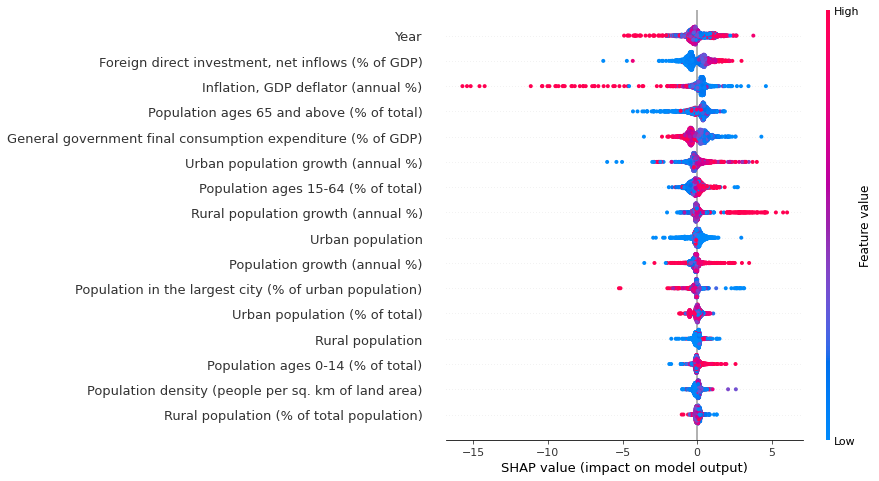

In [17]:
shap.summary_plot(shap_values, X_test)

In [29]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

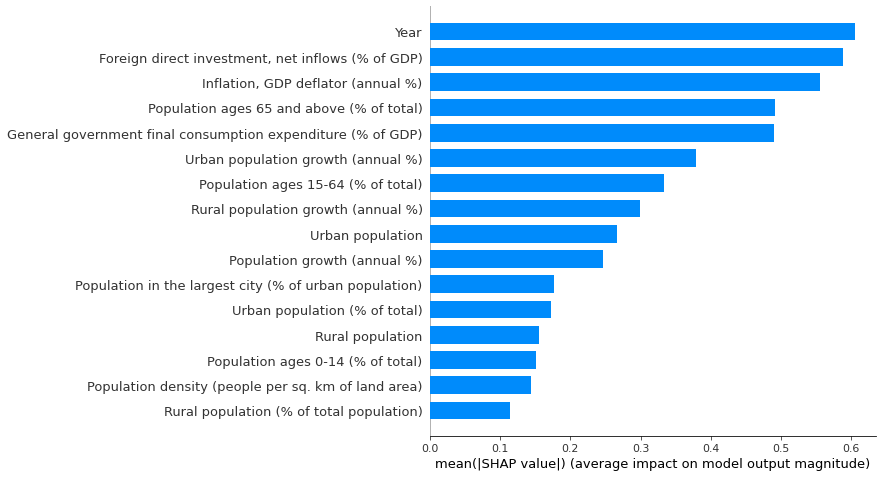

In [16]:
shap.summary_plot(shap_values, X_test, plot_type="bar")